In [1]:
import pandas as pd
from collections import Counter, defaultdict
import itertools
import random
import matplotlib.pyplot as plt
import more_itertools
import seaborn as sns
import csv

In [2]:
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import brown
import re
from sklearn.feature_extraction import text## Stop words list

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## 0. Pre-Processing - Remove Stop Words and Tokenize

In [6]:
df_raw = pd.read_csv("../input/joined_data.csv")
df_raw.drop(['Unnamed: 0','Unnamed: 5', 'Unnamed: 6'], 1, inplace=True)

C:\Users\18438\AppData\Local\Temp/ipykernel_18376/2218329103.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df_raw.drop(['Unnamed: 0','Unnamed: 5', 'Unnamed: 6'], 1, inplace=True)


In [35]:
print(f"{len(df_raw)} \t Total Rows")
print(f"{len(df_raw.drop_duplicates())} \t Total Non-Duplicate Rows")
print(f"{len(df_raw.drop_duplicates(subset = ['cleaned_song', 'cleaned_band']))} \t Total Rows of Non-Duplicate Band/Songs")

142643 	 Total Rows
140323 	 Total Non-Duplicate Rows
94117 	 Total Rows of Non-Duplicate Band/Songs


In [9]:
i = pd.read_csv("../input/stop words.csv", encoding='unicode_escape')['stop word'].tolist()
j = list(",.!#[]/'")

stopwords = set(i).union(j)

In [10]:
def preprocess(x):
    x = re.sub('[^a-z\s]', '', str(x).lower()) # COMMENT: semi-equivalent to Baharks code: x.strip(",.!#[];\"\"\/\'\\()!?$*+-><_~1234567890&:=^`")
    x = [w for w in x.split() if w not in stopwords]
    
    return ' '.join(x) or None

In [11]:
df['cleaned_lyrics'] = df.apply(lambda x: preprocess(x.Lyrics), axis = 1)
df.dropna(subset=['cleaned_lyrics'], inplace=True)

C:\Users\18438\AppData\Local\Temp/ipykernel_18376/2977327710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_lyrics'] = df.apply(lambda x: preprocess(x.Lyrics), axis = 1)
C:\Users\18438\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


### 0.1 Censor profanity, Edit "TRUE" and "FALSE", Stem, Lemmatize

In [12]:
# Stem the lyrics
stemmer = SnowballStemmer("english")
df['stemmed_lyrics'] = df['cleaned_lyrics'].apply(lambda x: ' '.join([stemmer.stem(y) for y in nltk.word_tokenize(x)]))

# Convert "TRUE" and "FALSE" to "true" and "false"
df['cleaned_lyrics'] = df['cleaned_lyrics'].str.replace('TRUE','true')
df['cleaned_lyrics'] = df['cleaned_lyrics'].str.replace('FALSE','false')
df['stemmed_lyrics'] = df['stemmed_lyrics'].str.replace('TRUE','true')
df['stemmed_lyrics'] = df['stemmed_lyrics'].str.replace('FALSE','false')

# Edit profanity by replacing words with versions where vowels are replaced by asteriks
profane_words = pd.read_table('../input/profane_words.txt', names=['words'])
profane_words['edited_words'] = profane_words['words'].str.replace(r'\B[aeiou]\B','*')
profane_words['profane_tuple'] = list(zip(profane_words['words'], profane_words['edited_words']))
# Editing 'cleaned_lyrics'
for tup in profane_words['profane_tuple']:
    df['cleaned_lyrics'] = df['cleaned_lyrics'].str.replace(tup[0],tup[1])
    df['stemmed_lyrics'] = df['stemmed_lyrics'].str.replace(tup[0],tup[1])


C:\Users\18438\AppData\Local\Temp/ipykernel_18376/825246250.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stemmed_lyrics'] = df['cleaned_lyrics'].apply(lambda x: ' '.join([stemmer.stem(y) for y in nltk.word_tokenize(x)]))
C:\Users\18438\AppData\Local\Temp/ipykernel_18376/825246250.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cleaned_lyrics'] = df['cleaned_lyrics'].str.replace('TRUE','true')
C:\Users\18438\AppData\Local\Temp/ipykernel_18376/825246250.py:7: SettingWithCopyWarning: 
A valu

## 1. Remove Non-English Songs

In [13]:
english_words = set(brown.words()) ## Cache

def classify_english_songs(lyrics):
    unique_words = set(lyrics.split())
    sample_size = min(50, len(unique_words))
    listed_lyrics = random.sample(set(lyrics.split()), sample_size)
    english_lyrics = [w for w in listed_lyrics if w in english_words]
    
    return len(english_lyrics)/sample_size
   
df['english_percentage'] = df.apply(lambda x: classify_english_songs(x.cleaned_lyrics), axis = 1)

C:\Users\18438\AppData\Local\Temp/ipykernel_18376/2950660547.py:6: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  listed_lyrics = random.sample(set(lyrics.split()), sample_size)
C:\Users\18438\AppData\Local\Temp/ipykernel_18376/2950660547.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['english_percentage'] = df.apply(lambda x: classify_english_songs(x.cleaned_lyrics), axis = 1)


(array([ 3062.,  2433.,  1070.,   235.,   263.,  1077.,  3294.,  8078.,
        26052., 48509.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

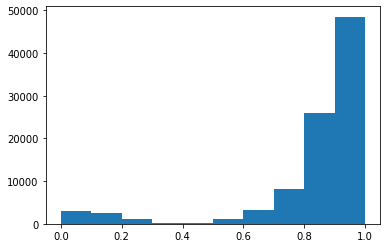

In [14]:
plt.hist(df['english_percentage'], 10)

In [15]:
#df[df['english_percentage'] < .6].to_csv("non_english_songs.csv", index=False)
print(f"Removed {len(df[df['english_percentage'] < .6])} Non-English Songs")
df = df[df['english_percentage'] > .6]

Removed 7897 Non-English Songs


## 2. Deduping song covers

In [16]:
#CASE 1: Two songs are the same (Count 5430)
song_dupes = df.groupby("cleaned_song").filter(lambda x: len(x) == 2) ##only keep songs that have one duplicate
print(len(song_dupes)/2)
song_dupes.sort_values("cleaned_song")

5132.0


,Band,cleaned_band,Lyrics,Song,cleaned_song,Column,title,cleaned_title,artist_name,cleaned_artist_name,duration,year,cleaned_lyrics,stemmed_lyrics,english_percentage
108095,Gram Parsons,gramparsons,"Was one thousand dollars wedding, supposed to ...",$1000 wedding,1000wedding,6154,$1000 wedding,1000wedding,gram parsons,gramparsons,303.17669,1974,dollars wedding supposed held day invitations ...,dollar wed suppos held day invit young bride g...,0.940000
15427,Willie Nelson,willienelson,It was a $1000 wedding supposed to be held the...,$1000 wedding,1000wedding,460780,$ 1000 wedding,1000wedding,willie nelson,willienelson,185.02485,2006,wedding supposed held day invitations young br...,wed suppos held day invit young bride groom pe...,0.920000
86778,Caliban,caliban,"A hundred suns, born to kill\nIt is madness, a...",100 suns,100suns,157595,100 suns (album version),100suns,caliban,caliban,236.27710,2004,suns born kill madness sun created man pervers...,sun born kill mad sun creat man pervers ironi ...,0.862069
140335,30 Seconds to Mars,30secondstomars,I believe in nothing\nNot the end and not the ...,100 suns,100suns,273910,100 suns,100suns,30 seconds to mars,30secondstomars,117.49832,2009,start earth stars day dark beating hearts suns...,start earth star day dark beat heart sun sin g...,1.000000
75833,Young Dro,youngdro,Young Dro\nY'all already know what it is when ...,100 yard dash,100yarddash,223340,100 yard dash (featuring xtaci) (explicit albu...,100yarddash,young dro,youngdro,179.53914,2006,young dro yall ecstasy dis grand hustle aye n*...,young dro yall ecstasi dis grand hustl aye n*g...,0.680000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72775,Sonata Arctica,sonataarctica,"Dancing on the borderline\n4-3-2-1\n\nHello, a...",zeroes,zeroes,2305,zeroes,zeroes,sonata arctica,sonataarctica,263.73179,2009,dancing borderline static fighting wars dwell ...,danc borderlin static fight war dwell hypocris...,0.880000
29751,Kottonmouth Kings,kottonmouthkings,The war on drugs is a war on me and if its not...,zero tolerance,zerotolerance,337969,zero tolerance,zerotolerance,kottonmouth kings,kottonmouthkings,188.62975,2002,war drugs war brave land free plant freedom ri...,war drug war brave land free plant freedom rin...,0.640000
18626,The Bluetones,thebluetones,"It was in those wonder-lust years, after I'd j...",zero tolerance,zerotolerance,418728,zero tolerance,zerotolerance,the bluetones,thebluetones,228.04853,2000,wonderlust years left school started notice ch...,wonderlust year left school start notic chang ...,0.780000
89118,Tata Young,tatayoung,Zoom Zoom in under my skin\nGotta slow down no...,zoom,zoom,4403,zoom,zoom,tata young,tatayoung,198.47791,2006,zoom zoom skin slow baby rush touch videos sto...,zoom zoom skin slow babi rush touch video stor...,0.885714


In [17]:
shifted = song_dupes.sort_values("year").groupby('cleaned_song').shift(1)
song_dupes_comp = song_dupes.join(shifted.rename(columns=lambda x: x+"_lag")).sort_values("cleaned_song")
song_dupes_comp = song_dupes_comp[['cleaned_song', 'Lyrics', 'Lyrics_lag', 'cleaned_band', 'cleaned_band_lag', 'year', 'year_lag', 'cleaned_lyrics', 'cleaned_lyrics_lag']].dropna()

In [18]:
song_dupes_comp.sort_values("cleaned_song").head()

,cleaned_song,Lyrics,Lyrics_lag,cleaned_band,cleaned_band_lag,year,year_lag,cleaned_lyrics,cleaned_lyrics_lag
15427,1000wedding,It was a $1000 wedding supposed to be held the...,"Was one thousand dollars wedding, supposed to ...",willienelson,gramparsons,2006,1974.0,wedding supposed held day invitations young br...,dollars wedding supposed held day invitations ...
140335,100suns,I believe in nothing\nNot the end and not the ...,"A hundred suns, born to kill\nIt is madness, a...",30secondstomars,caliban,2009,2004.0,start earth stars day dark beating hearts suns...,suns born kill madness sun created man pervers...
108612,100yarddash,I tried to run but couldn't get too far\nMy he...,Young Dro\nY'all already know what it is when ...,raphaelsaadiq,youngdro,2008,2006.0,heart bumpin runnin place matter hard touch lo...,young dro yall ecstasy dis grand hustle aye n*...
80128,1015saturdaynight,10:15 on a Saturday night\nAnd the tap\nDrips ...,10.15\n10.15\nSaturday night\nSaturday night\n...,thelivingend,thecure,1998,1978.0,saturday night tap drips streetlight sitting k...,saturday night saturday night tap drips tap dr...
69907,11Jul,I met her at the 7-11\nNow I'm in seventh heav...,I met her at the 7-11\nNow I'm in seventh heav...,thepostmarks,ramones,2008,1981.0,met seventh heaven true thought meet girl stan...,met seventh heaven true thought meet girl stan...


In [19]:
def one_hot_encoding(str_col: pd.Series,  max_features: int, ngram: str):
    """
    input:  str_col - pd.Series -> a column of strings
            ngram   - String    -> ngram option for bigrams
    output: tuple     -> np.SparseMatrix with one-hot-encoding representation, tokenized and joined list of strings
            ex. ([[1,0,1], [0,0,1]], ["red,blue","blue"])

    vectorizer.inverse_transform() returns a tokenized np.array of tokens.
    ex.  returns -> ['document,first,is,the,this',
             'document,is,second,the,this',
             'and,is,one,the,third,this',
             'document,first,is,the,this']
    """
    if ngram == "bigram":
        ngram_range = (2, 2)
    else:
        ngram_range = (1, 1)

    list_col = str_col.tolist()
    # COMMENT: could add token_pattern = r"\(.*?\)|([^\W_]+[^\s-]*)"
    # COMMENT: sklearn.CountVectorizer -> Removes stop words and punctuation and represents words as list of counts
    vectorizer = CountVectorizer(stop_words="english",
                                 binary=True,
                                 max_features=max_features,
                                 ngram_range=ngram_range).fit(list_col)

    x = vectorizer.transform(list_col)
    tokenized = [",".join(token_array) for token_array in vectorizer.inverse_transform(x.toarray())]

    return x, tokenized

In [20]:
def find_lyric_similarity(lyric1_col: pd.Series, lyric2_col: pd.Series):
    lyrics = pd.concat(
        [lyric1_col.reset_index(drop=True), lyric2_col.reset_index(drop=True)],
        ignore_index=True)
    encoded_lyrics = one_hot_encoding(lyrics, ngram='unigram', max_features = None)[0].toarray()

    lyrics_1 = encoded_lyrics[0:len(lyric1_col)]
    lyrics_2 = encoded_lyrics[len(lyric1_col):]

    cosine_scores = []
    for i in range(lyrics_1.shape[0]):
        score = cosine_similarity([lyrics_1[i]], [lyrics_2[i]])[0]
        cosine_scores.append(score)

    return cosine_scores

In [21]:
## COMMENT: True Covers
song_dupes_comp['score'] = find_lyric_similarity(song_dupes_comp['cleaned_lyrics'], song_dupes_comp['cleaned_lyrics_lag'])
song_dupes_comp[song_dupes_comp['score']>.95].head() ## COMMENT: 596 songs are actual covers

,cleaned_song,Lyrics,Lyrics_lag,cleaned_band,cleaned_band_lag,year,year_lag,cleaned_lyrics,cleaned_lyrics_lag,score
15427,1000wedding,It was a $1000 wedding supposed to be held the...,"Was one thousand dollars wedding, supposed to ...",willienelson,gramparsons,2006,1974.0,wedding supposed held day invitations young br...,dollars wedding supposed held day invitations ...,[0.9752399172382473]
69907,11Jul,I met her at the 7-11\nNow I'm in seventh heav...,I met her at the 7-11\nNow I'm in seventh heav...,thepostmarks,ramones,2008,1981.0,met seventh heaven true thought meet girl stan...,met seventh heaven true thought meet girl stan...,[0.9999999999999999]
62314,1999,I was dreamin' when I wrote this\nForgive me i...,I was dreamin' when I wrote this\nForgive me i...,themikeflowerspops,prince,1996,1993.0,dreamin wrote forgive astray woke mornin sworn...,dreamin wrote forgive astray woke mornin sworn...,[1.0]
29421,22steps,If I were him\nI'd know your birthday\nJust wh...,"If I were him,\nI'd know your birthday.\nJust ...",damienleith,andystochansky,2007,2002.0,birthday colors wear buy bikes ride sundays re...,birthday colors wear buy bikes ride sundays re...,[0.959166304662544]
132279,2hb,Oh I was moved by your screen dream\nCelluloid...,Oh I was moved by your screen dream\nCelluloid...,roxymusic,bryanferry,1995,1976.0,moved screen dream celluloid pictures living d...,moved screen dream celluloid pictures living d...,[1.0000000000000002]


In [22]:
unique = df.merge(song_dupes_comp[song_dupes_comp['score']>.95], how='left')
print(f"Found {len(unique[~unique['Lyrics_lag'].isnull()])} Song Cover duplicates")
unique = unique[unique['Lyrics_lag'].isnull()]
len(unique)

Found 578 Song Cover duplicates


85355

### 2.2 Pre-Processing for Market Basket Analysis (MBA) - "only_popular_word" column

In [23]:
flatlist = [list(set(sublist.split())) for sublist in unique['cleaned_lyrics'].tolist()]
flatlist = [item for sublist in flatlist for item in sublist]
## word count

word_count = dict(Counter(flatlist))
word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))

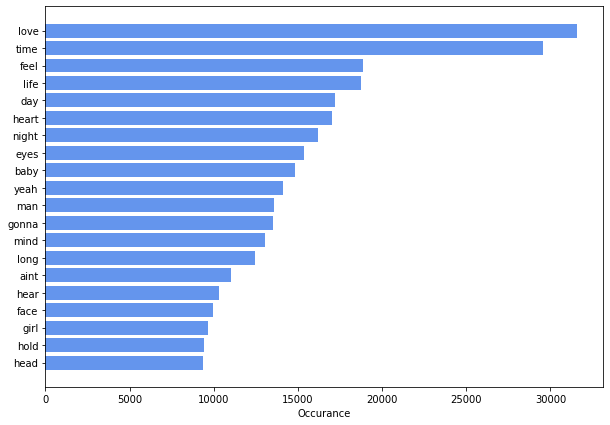

C:\Users\18438\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.8924

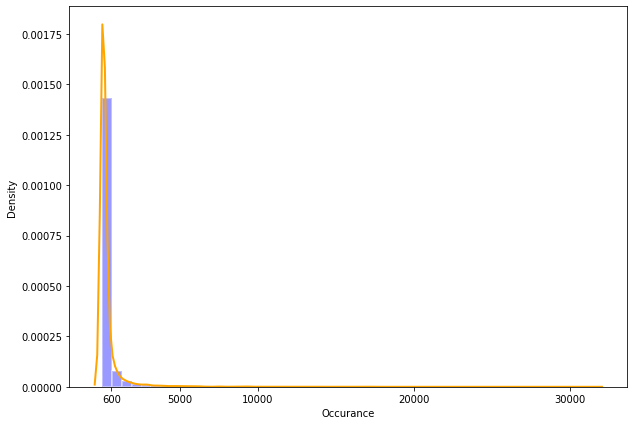

In [24]:
## For the purpose of graph
## Top 20 words-First graph
pop_words_graph = more_itertools.take(20, word_count.items())
plt.figure(figsize=(10,7))
x_val = [x[0] for x in pop_words_graph]
y_val = [x[1] for x in pop_words_graph]
plt.barh(x_val,y_val, color='#6495ED')
plt.xlabel("Occurance")
plt.gca().invert_yaxis()
plt.rc('font', size=10) 
plt.show()


# Second graph
pop_words_graph = more_itertools.take(10000, word_count.items())
x = pd.Series([i[1] for i in pop_words_graph])
plt.figure(figsize=(10,7))
ax = sns.distplot(x, bins=50, kde=True, hist_kws=dict(color= "#0000FF", edgecolor="white", linewidth=2),\
                 kde_kws=dict(color= "orange", linewidth=2))
plt.xticks([600, 5000, 10000, 20000, 30000])
plt.xlabel("Occurance")


less_1000 = len([i for i in x if i<600])
less_1000/len(x)

In [25]:
## top 1200 words list is saved
## 1200 seems the good threshhold

pop_words_selected = more_itertools.take(1200, word_count.items())
pop_words_selected = [x[0] for x in pop_words_selected]

with open('../output/word_list.csv', mode='w') as word_file:
    word_file = csv.writer(word_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    word_file.writerow(pop_words_selected)

In [26]:
    ## select lyrics that have the top words
def popular_words(row, popular):

        return [w for w in row.split() if w in popular]
    
unique['only_popular_word'] = unique.apply(lambda x: popular_words(x['cleaned_lyrics'], pop_words_selected), axis=1)

## 3. Picking Anchor Words

In [27]:
#COMMENT: Models changed on different time-periods
period_1 = unique[unique['year'] < 1983]
period_2 = unique[(unique['year'] >= 1983) & (unique['year'] <=1991)]
period_3 = unique[(unique['year'] > 1991)]

In [39]:
def get_top_n(flatlist, n):
    ## word count
    word_count = Counter(flatlist)
    word_count = dict(sorted(word_count.items(), key=lambda x: x[1], reverse=True))

    top_100 = list(word_count.keys())[0:(n-1)]
    
    return top_100
    
flat_p1 = list(itertools.chain(*[lyrics.split() for lyrics in period_1['cleaned_lyrics'].tolist()]))
flat_p2 = list(itertools.chain(*[lyrics.split() for lyrics in period_2['cleaned_lyrics'].tolist()]))
flat_p3 = list(itertools.chain(*[lyrics.split() for lyrics in period_3['cleaned_lyrics'].tolist()]))

top_100_p1 = get_top_n(flat_p1, 250)
top_100_p2 = get_top_n(flat_p2, 250)
top_100_p3 = get_top_n(flat_p3, 250)

top_i = 0
j = 0
top_100_words = []
while top_i < 100:
    if (top_100_p1[j] in top_100_p2) and (top_100_p1[j] in top_100_p2):
        top_100_words.append(top_100_p1[j])
        top_i+=1
    j += 1

X = set(top_100_p1).intersection(top_100_p2).intersection(top_100_p3)

In [40]:
anchor_words = top_100_words

## 4. Co-Occurence (counted weighting)

In [31]:
output_df = pd.DataFrame()

In [32]:
## Flat list for periods
flatList_p1 = list(period_1["only_popular_word"])
flatList_p2 = list(period_2["only_popular_word"])
flatList_p3 = list(period_3["only_popular_word"])

period_map = {1: "Before 1983", 2: "Between 1983 and 1991", 3: "After 1991"}

In [33]:
## Cout co occurances in period 1

scaler = MinMaxScaler()
def cooccurrence(items):
    """
    Updates a dictionary of pair counts for
    all pairs of items in a given itemset.
    """
    pair_counts = defaultdict(int)
    for item in items:
        for (a, b) in itertools.combinations(item, 2):
            if a != b:
                sorted_comb = sorted((a,b))
                tuple_comb = tuple(sorted_comb)

                pair_counts[tuple_comb] += 1

    return pair_counts

for i, period in enumerate([flatList_p1, flatList_p2, flatList_p3]):
    cooccurrence_dict = cooccurrence(period)
    first_word = [w1 for w1,w2 in cooccurrence_dict.keys()]
    second_word = [w2 for w1,w2 in cooccurrence_dict.keys()]
    df = pd.DataFrame({'first_word':first_word
                  , 'second_word': second_word
                  , 'weight': list(cooccurrence_dict.values())})
    
    df['scaled_weight'] = scaler.fit_transform(df[['weight']])
    df['method'] = 'Co-Occurrence by Count'
    df['period'] = period_map[i+1]
    
    df.to_csv(f'../output/node_edge_p{i+1}.csv', index=False)
    output_df = pd.concat([output_df, df], ignore_index=False)

## 5. Co-Occurrence (MBA support weighting)

In [34]:
from apyori import apriori

In [36]:

for i, period in enumerate([flatList_p1, flatList_p2, flatList_p3]):
    algo = apriori(period, min_support=0.001, min_confidence=0.001, min_lift=2, max_length=2)
    results = list(algo)

    ## pd.DataFrame(results) and save
    association_rule = pd.DataFrame(results).sort_values(by=['support'], ascending=False)
    first_word = []
    second_word = []
    for _, row in association_rule.iterrows():
        w1, w2 = tuple(row['items'])
        first_word.append(w1)
        second_word.append(w2)
    df = pd.DataFrame({'first_word': first_word, 'second_word': second_word, 'weight': association_rule.support})
    
    df['scaled_weight'] = scaler.fit_transform(df[['weight']])
    df['method'] = 'Co-Occurence MBA'
    df['period'] = period_map[i+1]
    
    df.sort_values(by='weight', ascending=False).to_csv(f'../output/association_rule_P{i+1}.csv', index=False)   
    output_df = pd.concat([output_df, df], ignore_index=False)

## 6. kNN - Cosine Similarity of Word2Vec Vectors

In [37]:
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [41]:
## LINK: https://radimrehurek.com/gensim/models/word2vec.html
for i, period in enumerate([period_1, period_2, period_3]):
    lyric_list = [song_lyrics.split() for song_lyrics in period['cleaned_lyrics'].tolist()]
    model = Word2Vec(sentences=lyric_list, vector_size=300, window=5, min_count=1, workers=4)

    vocab = set(anchor_words)
    for word in anchor_words:
        word2vec_top = model.wv.most_similar(word, topn=10)
        vocab = vocab.union([w for w,p in word2vec_top])

    rows = []
    for (a, b) in itertools.combinations(vocab, 2):
        if a != b:
            weight = model.wv.similarity(a,b)
            rows.append([a,b,weight])

    word2vec_df = pd.DataFrame(rows, columns=['first_word', 'second_word', 'weight'])
    

    ##word2vec_df = word2vec_df[word2vec_df['weight']>.75]
    word2vec_df['scaled_weight'] = scaler.fit_transform(word2vec_df[['weight']])
    
    word2vec_df.to_csv(f"../output/word2vec_p{i+1}.csv", index=False)
    word2vec_df['method'] = 'Word2Vec Cosine Similarity'
    word2vec_df['period'] = period_map[i+1]
    
    
    output_df = pd.concat([output_df, word2vec_df], ignore_index=False)

# 7. Thresholding

In [42]:
def get_top_nodes(df, limit):
    counter = 0
    vocab = []

    for i, row in df.sort_values('scaled_weight', ascending=False).iterrows():
        first_word = row['first_word']
        second_word = row['second_word']
        
        if first_word not in vocab:
            vocab.append(first_word)
            counter+=1
        
        if second_word not in vocab:
            vocab.append(second_word)
            counter+=1
        
        if counter >= limit:
            return vocab
    
def get_top_edges(node_list, df):
    return df[df['first_word'].isin(node_list) & df['second_word'].isin(node_list)]


def get_edges_for_word(word, df):
    top_word_edges = pd.DataFrame()
    for period in df.period.unique():
        for method in df.method.unique():
            sub_df = df[(df.method==method) & (df.period==period)]
            sub_df = sub_df[(sub_df.first_word==word) | (sub_df.second_word==word)]
            sub_df = sub_df.sort_values('scaled_weight', ascending=False)[0:5]
            top_word_edges = pd.concat([top_word_edges, sub_df], ignore_index =True)
            
    return top_word_edges


def set_weight_color(threshold_df, color_probs = [.80, .90, 1]):
    size = len(threshold_df)
    col1 = round(size*color_probs[0])
    col2 = round(size*color_probs[1])
    
    threshold_df.reset_index(inplace=True)
    threshold_df['color'] = 'color1'
    
    threshold_df.loc[threshold_df.index > col1, 'color'] = 'color2'
    threshold_df.loc[threshold_df.index > col2, 'color'] = 'color3'
    
    return threshold_df

In [43]:
#cooccurrence Edge Threshold 0.045845761
threshold_df = pd.DataFrame()
for method in output_df['method'].unique():
    for period in output_df['period'].unique():
        sub_df = output_df[(output_df.method==method) & (output_df.period==period)]
        top_nodes = get_top_nodes(sub_df, 100)
        top_edges = get_top_edges(top_nodes, sub_df).sort_values('scaled_weight', ascending=False)[0:499]

        threshold_ = set_weight_color(top_edges)
        threshold_df = pd.concat([threshold_df, threshold_], ignore_index=False)



In [44]:
threshold_df.to_csv("../output/threshold_df.csv", index=True)